In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#cuda
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
#ネットワークはcudaにまとめて投げるのでオブジェクト化する
#Discriminatorネットワーク
class Dis(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        #全結合層にする
        self.disnet = nn.Sequential(
            #28*28の画像を入力とした判別器
            nn.Linear(28*28, 1024), 
            #Leaky ReLUはデフォだとα=0.01がいいらしい
            nn.LeakyReLU(0.01), 
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.01),
            nn.Linear(512, 1), 
            #本物かどうかの判別なのでSigmoidで二値分類
            nn.Sigmoid()
        )
        
    def forward(self, img):
        #テンソルをベクトルにする
        input = img.view(img.size(0),-1)
        #あとは順伝播
        y = self.disnet(input)
        return y
        

In [4]:
#Generatorネットワーク
class Gen(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.gennet = nn.Sequential(
            #ランダムなノイズを入力(100とかにする)
            nn.Linear(100, 512), 
            nn.LeakyReLU(0.01), 
            nn.Linear(512, 1024), 
            nn.LeakyReLU(0.01), 
            nn.Linear(1024, 28*28), 
            #ピクセルなのでTanh
            nn.Tanh()
        )
        
    def forward(self, noise):
        y = self.gennet(noise)
        #グレースケールなのでチャンネル数は1
        y = y.view(-1, 1, 28, 28)
        return y

In [5]:
#インスタンスをGPUへコピー
dis = Dis().to(device)
gen = Gen().to(device)

#真値のカテゴリが2つならバイナリクロスエントロピーがいいらしい
#たくさんカテゴリがあるならクロスエントロピーがいいらしい
loss = nn.BCELoss()

#パラメータ最適化手法
#学習率とかはデフォでやる
dis_opt = optim.Adam(dis.parameters(), betas=(0.5, 0.999))
gen_opt = optim.Adam(gen.parameters(), betas=(0.5, 0.999))

#データ変換、正規化、読み込み
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])
dataset = datasets.MNIST("./data/", train=True, download=True, transform=trans)

In [6]:
#学習関数
def train(data_load, epochs, batch):
    #50エポック回す
    #Lossの動きを見る用
    lossdata_dis = []
    lossdata_gen = []
    for epoch in range(epochs):
        #イテレーション分回す
        for batch_index, (img, _) in enumerate(data_load):
            batch_index += 1
            #本物の画像を判別器に入力，判定結果を出力
            real_img = img.to(device)
            real_y = dis(real_img)
            #正解ラベル作成
            real_label = torch.ones(real_img.shape[0], 1).to(device=device)
            #偽物の画像を判別機に入力
            #noise
            noise = torch.rand(real_img.shape[0], 100)
            #-1~1へスケーリング
            noise = ((noise - 0.5) / 0.5).to(device=device)
            fake_img = gen(noise)
            fake_y = dis(fake_img)
            fake_label = torch.zeros(fake_img.shape[0], 1).to(device=device)
            
            #判別機の出力, 正解を結合
            result = torch.cat((real_y, fake_y), 0)
            ans = torch.cat((real_label, fake_label), 0)
            
            #BCEで損失計算
            #判別器
            dis_loss = loss(result, ans)
            dis_opt.zero_grad()
            dis_loss.backward()
            dis_opt.step()
            lossdata_dis.append(dis_loss.item())
            
            #生成器
            #偽物の画像を判別機に入力
            #noise
            noise = torch.rand(real_img.shape[0], 100)
            #-1~1へスケーリング
            noise = ((noise - 0.5) / 0.5).to(device=device)
            fake_img = gen(noise)
            fake_y = dis(fake_img)
            label = torch.ones(fake_img.shape[0], 1).to(device=device)
            
            gen_loss = loss(fake_y, label)
            gen_opt.zero_grad()
            gen_loss.backward()
            gen_opt.step()
            lossdata_gen.append(gen_loss.item())
            
            
            if (batch_index +1) % 100 == 0 or batch_index == len(data_load):
                print(f'現在{epoch}エポック{batch_index}イテレーション')
                print(f'判別器のLossは{dis_loss.item()}')
                print(f'生成器のLossは{gen_loss.item()}')
            
    return lossdata_dis, lossdata_gen

In [7]:
#とりあえずこのバッチサイズで学習
epochs = 50
batch = 64
train_load = DataLoader(dataset=dataset, batch_size=batch, shuffle=True)

lossdata_dis, lossdata_gen = train(train_load, epochs, batch)

現在0エポック99イテレーション
判別器のLossは0.46360108256340027
生成器のLossは0.6523828506469727
現在0エポック199イテレーション
判別器のLossは0.43765783309936523
生成器のLossは1.783003330230713
現在0エポック299イテレーション
判別器のLossは0.3209110498428345
生成器のLossは1.654253602027893
現在0エポック399イテレーション
判別器のLossは0.36696118116378784
生成器のLossは1.3633089065551758
現在0エポック499イテレーション
判別器のLossは0.6288812160491943
生成器のLossは1.1026625633239746
現在0エポック599イテレーション
判別器のLossは0.7799410820007324
生成器のLossは0.8192521333694458
現在0エポック699イテレーション
判別器のLossは0.5783548355102539
生成器のLossは0.5943412780761719
現在0エポック799イテレーション
判別器のLossは0.4523683190345764
生成器のLossは1.3808693885803223
現在0エポック899イテレーション
判別器のLossは0.492341548204422
生成器のLossは1.4669950008392334
現在0エポック938イテレーション
判別器のLossは0.5033257007598877
生成器のLossは0.7930788993835449
現在1エポック99イテレーション
判別器のLossは0.4494096636772156
生成器のLossは0.9480409622192383
現在1エポック199イテレーション
判別器のLossは0.5963166952133179
生成器のLossは1.5244271755218506
現在1エポック299イテレーション
判別器のLossは0.5898033380508423
生成器のLossは0.9507895112037659
現在1エポック399イテレーション
判別器のLossは0.56439125537

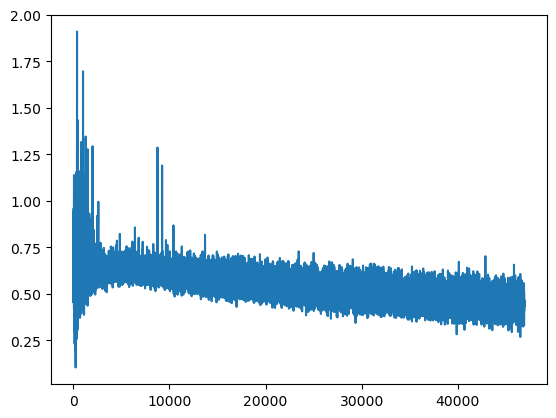

In [8]:
plt.plot(lossdata_dis)

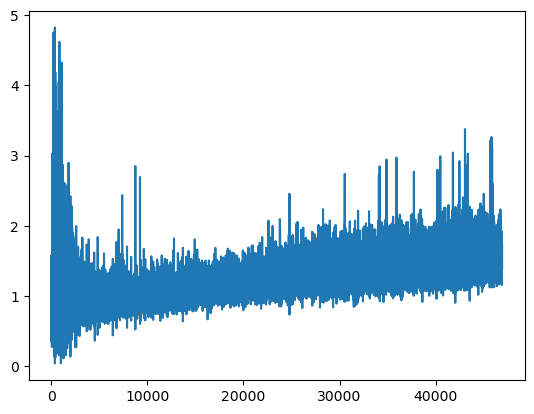

In [9]:
plt.plot(lossdata_gen)

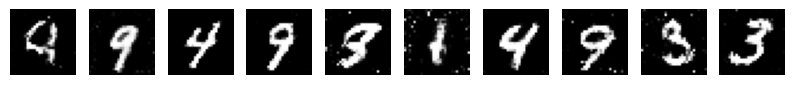

In [10]:
import matplotlib.pyplot as plt

# 生成器にランダムなノイズを入力して画像を生成
with torch.no_grad():
    # ノイズの生成
    noise = torch.randn(10, 100, device=device)
    
    # 生成器にノイズを入力し、画像を生成
    generated_images = gen(noise)

# 生成された画像を表示
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(generated_images[i].cpu().detach().numpy().squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:

# テストデータの読み込み
# test_dataはMNISTのテストデータセット

# 生成器にノイズを入力して画像を生成し、それを保存するループ
for i, (real_images, _) in enumerate(train_load):
    # ノイズの生成
    #偽物の画像を判別機に入力
    #noise
    real_img = real_images.to(device)
    noise = torch.rand(real_img.shape[0],100)
    #-1~1へスケーリング
    noise = ((noise - 0.5) / 0.5).to(device=device)
    out = gen(noise)
    
    # 生成された画像を表示
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(out[0].permute(1, 2, 0).cpu().detach().numpy())
    plt.show()


In [21]:
#バッチサイズ128
epochs = 50
batch = 128
train_load = DataLoader(dataset=dataset, batch_size=batch, shuffle=True)

lossdata_dis, lossdata_gen = train(train_load, epochs, batch)

現在0エポック99イテレーション
判別器のLossは0.3343127369880676
生成器のLossは1.6124279499053955
現在0エポック199イテレーション
判別器のLossは0.38602328300476074
生成器のLossは1.6275345087051392
現在0エポック299イテレーション
判別器のLossは0.3650635778903961
生成器のLossは1.7936046123504639
現在0エポック399イテレーション
判別器のLossは0.45905929803848267
生成器のLossは1.974494218826294
現在0エポック469イテレーション
判別器のLossは0.46604737639427185
生成器のLossは1.629450798034668
現在1エポック99イテレーション
判別器のLossは0.4243636429309845
生成器のLossは1.6542787551879883
現在1エポック199イテレーション
判別器のLossは0.4394037425518036
生成器のLossは1.5094940662384033
現在1エポック299イテレーション
判別器のLossは0.36009305715560913
生成器のLossは1.6646428108215332
現在1エポック399イテレーション
判別器のLossは0.4253593683242798
生成器のLossは2.1287198066711426
現在1エポック469イテレーション
判別器のLossは0.35707396268844604
生成器のLossは1.738137125968933
現在2エポック99イテレーション
判別器のLossは0.38938578963279724
生成器のLossは1.8472645282745361
現在2エポック199イテレーション
判別器のLossは0.43945226073265076
生成器のLossは1.9407894611358643
現在2エポック299イテレーション
判別器のLossは0.38885533809661865
生成器のLossは1.7572065591812134
現在2エポック399イテレーション
判別器のLossは0.3764715

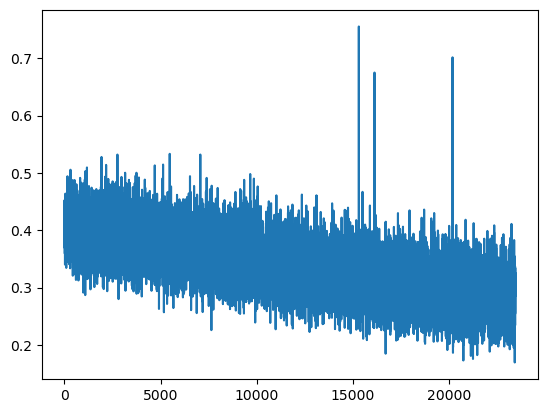

In [22]:
plt.plot(lossdata_dis)

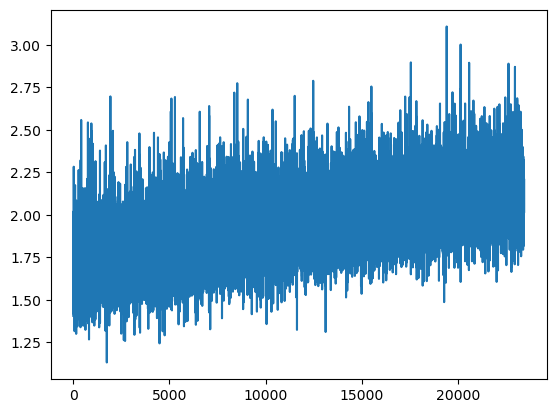

In [23]:
plt.plot(lossdata_gen)

In [26]:
#層を変更&LeakyReLU→0.005に
class Dis(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        #全結合層にする
        self.disnet = nn.Sequential(
            #28*28の画像を入力とした判別器
            nn.Linear(28*28, 512), 
            #Leaky ReLUはデフォだとα=0.01がいいらしい
            nn.LeakyReLU(0.01), 
            nn.Linear(512, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 1), 
            #本物かどうかの判別なのでSigmoidで二値分類
            nn.Sigmoid()
        )
        
    def forward(self, img):
        #テンソルをベクトルにする
        input = img.view(img.size(0),-1)
        #あとは順伝播
        y = self.disnet(input)
        return y

In [27]:
#Generatorネットワーク
class Gen(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.gennet = nn.Sequential(
            #ランダムなノイズを入力(100とかにする)
            nn.Linear(100, 256), 
            nn.LeakyReLU(0.01), 
            nn.Linear(256, 512), 
            nn.LeakyReLU(0.01), 
            nn.Linear(512, 28*28), 
            #ピクセルなのでTanh
            nn.Tanh()
        )
        
    def forward(self, noise):
        y = self.gennet(noise)
        #グレースケールなのでチャンネル数は1
        y = y.view(-1, 1, 28, 28)
        return y

In [28]:
#良かったバッチサイズでやる
epochs = 50
batch = 64
train_load = DataLoader(dataset=dataset, batch_size=batch, shuffle=True)

lossdata_dis, lossdata_gen = train(train_load, epochs, batch)

現在0エポック99イテレーション
判別器のLossは0.21478036046028137
生成器のLossは2.1834986209869385
現在0エポック199イテレーション
判別器のLossは0.18095646798610687
生成器のLossは2.3962411880493164
現在0エポック299イテレーション
判別器のLossは0.2797009348869324
生成器のLossは2.2320656776428223
現在0エポック399イテレーション
判別器のLossは0.28591251373291016
生成器のLossは2.225005626678467
現在0エポック499イテレーション
判別器のLossは0.19833476841449738
生成器のLossは2.0352261066436768
現在0エポック599イテレーション
判別器のLossは0.16236478090286255
生成器のLossは2.1698713302612305
現在0エポック699イテレーション
判別器のLossは0.2749527394771576
生成器のLossは2.115161895751953
現在0エポック799イテレーション
判別器のLossは0.2610960006713867
生成器のLossは2.1185293197631836
現在0エポック899イテレーション
判別器のLossは0.28329938650131226
生成器のLossは2.1821298599243164
現在0エポック938イテレーション
判別器のLossは0.15795516967773438
生成器のLossは2.514164447784424
現在1エポック99イテレーション
判別器のLossは0.36559078097343445
生成器のLossは2.273676633834839
現在1エポック199イテレーション
判別器のLossは0.27379247546195984
生成器のLossは2.039581298828125
現在1エポック299イテレーション
判別器のLossは0.26838555932044983
生成器のLossは1.955698847770691
現在1エポック399イテレーション
判別器のLossは0.2117207

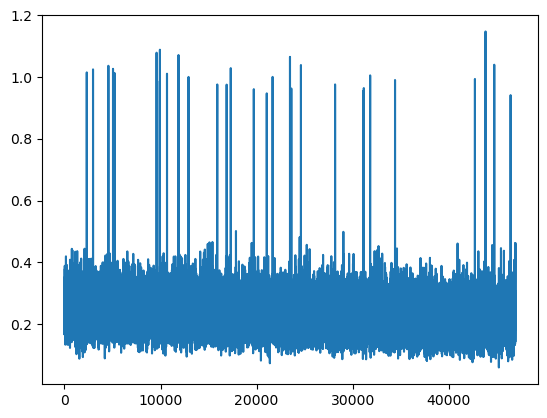

In [29]:
plt.plot(lossdata_dis)

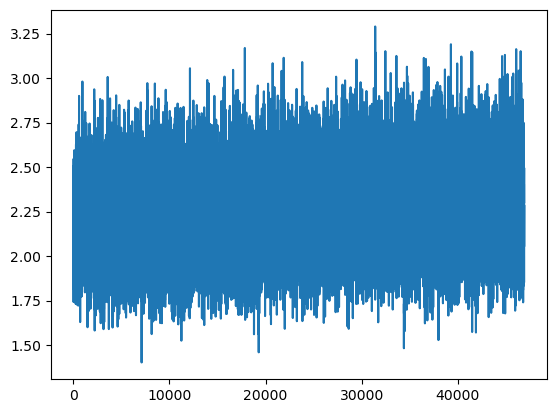

In [32]:
plt.plot(lossdata_gen)

In [33]:
#層を複雑化
class Dis(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        #全結合層にする
        self.disnet = nn.Sequential(
            #28*28の画像を入力とした判別器
            nn.Linear(28*28, 1024), 
            #Leaky ReLUはデフォだとα=0.01がいいらしい
            nn.LeakyReLU(0.01), 
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.01),
            nn.Linear(2048, 4096),
            nn.LeakyReLU(0.01), 
            nn.Linear(4096, 2048),
            nn.LeakyReLU(0.01),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.005),
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 1), 
            #本物かどうかの判別なのでSigmoidで二値分類
            nn.Sigmoid()
        )
        
    def forward(self, img):
        #テンソルをベクトルにする
        input = img.view(img.size(0),-1)
        #あとは順伝播
        y = self.disnet(input)
        return y

In [34]:
#Generatorネットワーク
class Gen(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.gennet = nn.Sequential(
            #ランダムなノイズを入力(100とかにする)
            nn.Linear(100, 256), 
            nn.LeakyReLU(0.01), 
            nn.Linear(256, 1024), 
            nn.LeakyReLU(0.01), 
            nn.Linear(1024, 4096), 
            nn.LeakyReLU(0.01),
            nn.Linear(4096, 1024), 
            nn.LeakyReLU(0.01),
            nn.Linear(1024, 512), 
            nn.LeakyReLU(0.01),
            nn.Linear(512, 28*28), 
            #ピクセルなのでTanh
            nn.Tanh()
        )
        
    def forward(self, noise):
        y = self.gennet(noise)
        #グレースケールなのでチャンネル数は1
        y = y.view(-1, 1, 28, 28)
        return y

In [35]:
#良かったバッチサイズでやる
epochs = 30
batch = 64
train_load = DataLoader(dataset=dataset, batch_size=batch, shuffle=True)

lossdata_dis, lossdata_gen = train(train_load, epochs, batch)

現在0エポック99イテレーション
判別器のLossは0.2400527000427246
生成器のLossは2.183176279067993
現在0エポック199イテレーション
判別器のLossは0.18990866839885712
生成器のLossは2.253326177597046
現在0エポック299イテレーション
判別器のLossは0.25579145550727844
生成器のLossは2.1477956771850586
現在0エポック399イテレーション
判別器のLossは0.22441354393959045
生成器のLossは2.4126241207122803
現在0エポック499イテレーション
判別器のLossは0.23934227228164673
生成器のLossは2.211724042892456
現在0エポック599イテレーション
判別器のLossは0.13638271391391754
生成器のLossは2.6508374214172363
現在0エポック699イテレーション
判別器のLossは0.09175707399845123
生成器のLossは2.6215903759002686
現在0エポック799イテレーション
判別器のLossは0.18958377838134766
生成器のLossは2.3270840644836426
現在0エポック899イテレーション
判別器のLossは0.1850988268852234
生成器のLossは2.742408275604248
現在0エポック938イテレーション
判別器のLossは0.2181255966424942
生成器のLossは1.8336018323898315
現在1エポック99イテレーション
判別器のLossは0.20569854974746704
生成器のLossは2.544032096862793
現在1エポック199イテレーション
判別器のLossは0.24873031675815582
生成器のLossは2.156111717224121
現在1エポック299イテレーション
判別器のLossは0.19389525055885315
生成器のLossは2.042524814605713
現在1エポック399イテレーション
判別器のLossは0.30126261

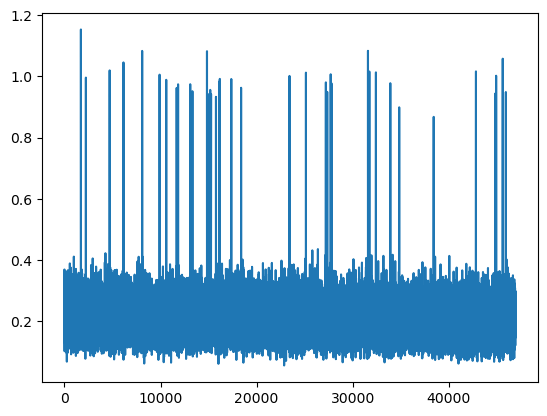

In [36]:
plt.plot(lossdata_dis)

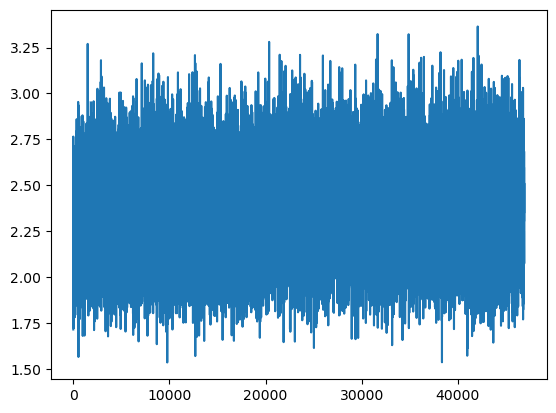

In [37]:
plt.plot(lossdata_gen)

In [12]:
#層を複雑化
class Dis(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        #全結合層にする
        self.disnet = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        nn.LeakyReLU(negative_slope=0.2),
        nn.Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        nn.InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
        nn.LeakyReLU(negative_slope=0.2),
        nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
        nn.InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
        nn.LeakyReLU(negative_slope=0.2),
        nn.Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False),
        nn.Sigmoid()
        )
        
    def forward(self, img):
        #テンソルをベクトルにする
        input = img.view(img.size(0),-1)
        #あとは順伝播
        y = self.disnet(input)
        return y

In [13]:
#Generatorネットワーク
class Gen(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.gennet = nn.Sequential(
            #ランダムなノイズを入力(100とかにする)
            nn.ConvTranspose2d(100, 128, karnel_size = (4, 4), stride = (1, 1), bias=False), 
            nn.InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False), 
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.Tanh()
        )
        
    def forward(self, noise):
        y = self.gennet(noise)
        #グレースケールなのでチャンネル数は1
        y = y.view(-1, 1, 28, 28)
        return y

In [14]:
epochs = 30
batch = 64
train_load = DataLoader(dataset=dataset, batch_size=batch, shuffle=True)

lossdata_dis, lossdata_gen = train(train_load, epochs, batch)

現在0エポック99イテレーション
判別器のLossは0.3833840489387512
生成器のLossは1.5459544658660889
現在0エポック199イテレーション
判別器のLossは0.43916016817092896
生成器のLossは1.442641258239746
現在0エポック299イテレーション
判別器のLossは0.45343899726867676
生成器のLossは1.6657400131225586
現在0エポック399イテレーション
判別器のLossは0.43021681904792786
生成器のLossは1.3318036794662476
現在0エポック499イテレーション
判別器のLossは0.44706958532333374
生成器のLossは1.2874524593353271
現在0エポック599イテレーション
判別器のLossは0.3850898742675781
生成器のLossは1.5350106954574585
現在0エポック699イテレーション
判別器のLossは0.42053747177124023
生成器のLossは1.5656371116638184
現在0エポック799イテレーション
判別器のLossは0.5204843282699585
生成器のLossは1.5959115028381348
現在0エポック899イテレーション
判別器のLossは0.40446245670318604
生成器のLossは1.5816184282302856
現在0エポック938イテレーション
判別器のLossは0.4792281985282898
生成器のLossは1.2967748641967773
現在1エポック99イテレーション
判別器のLossは0.4613218605518341
生成器のLossは1.5737797021865845
現在1エポック199イテレーション
判別器のLossは0.38440197706222534
生成器のLossは1.677689790725708
現在1エポック299イテレーション
判別器のLossは0.3520967960357666
生成器のLossは1.6194335222244263
現在1エポック399イテレーション
判別器のLossは0.436722

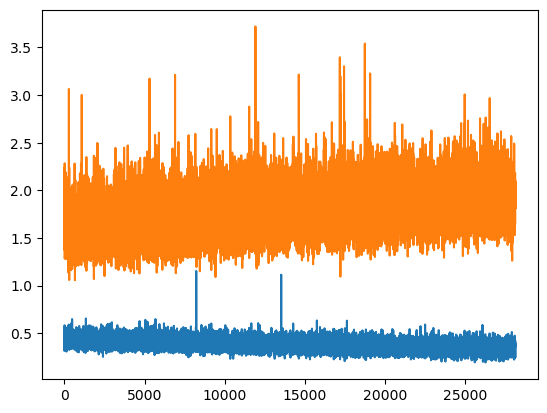

In [17]:
plt.plot(lossdata_dis)
plt.plot(lossdata_gen)

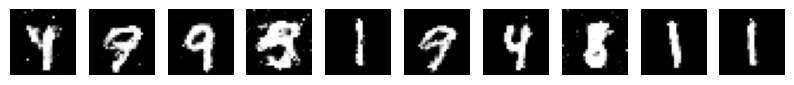

In [16]:
import matplotlib.pyplot as plt

# 生成器にランダムなノイズを入力して画像を生成
with torch.no_grad():
    # ノイズの生成
    noise = torch.randn(10, 100, device=device)
    
    # 生成器にノイズを入力し、画像を生成
    generated_images = gen(noise)

# 生成された画像を表示
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(generated_images[i].cpu().detach().numpy().squeeze(), cmap='gray')
    plt.axis('off')
plt.show()